In [90]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold

### Load dataset

In [91]:
df = pd.read_csv('Hitters.csv')
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [92]:
# As before we have 59 null value 
df = df.iloc[:, 1:]
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [93]:
#3 Let's remove null values
df_hitter = df.dropna()

In [94]:
# Check what we get
df_hitter.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

In [95]:
print('Shape before removal of null values {}'.format(df.shape))
print('Shape after removal of null values {}'.format(df_hitter.shape))

Shape before removal of null values (322, 20)
Shape after removal of null values (263, 20)


In [96]:
# Object columns:
object_col = df_hitter.dtypes == object
object_col[object_col == True].index

Index(['League', 'Division', 'NewLeague'], dtype='object')

In [97]:
df_hitter[object_col[object_col == True].index].head()

,League,Division,NewLeague
1,N,W,N
2,A,W,A
3,N,E,N
4,N,E,N
5,A,W,A


In [98]:
df_hitter[object_col[object_col == True].index].describe()

,League,Division,NewLeague
count,263,263,263
unique,2,2,2
top,A,W,A
freq,139,134,141


In [99]:
# dummy variables:
dummies = pd.get_dummies(df_hitter[object_col[object_col == True].index])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [100]:
# Intotal 6 columns with dummy variables, we just need 3 of them:
df_dummies = dummies.iloc[:, 1::2] 
df_dummies.head()

,League_N,Division_W,NewLeague_N
1,1,1,1
2,0,1,0
3,1,0,1
4,1,0,1
5,0,1,0


In [101]:
df_hitter.drop(object_col[object_col == True].index, axis = 1, inplace = True)

C:\Users\u0125384\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [102]:
# Concatenate dataframe with dummy variables to one with float varianles.
df = pd.concat([df_hitter, df_dummies], axis = 1)
df.shape

(263, 20)

In [103]:
# Let's see the head of the dataframe: 
df.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [104]:
# Get the features of the dataframe
features = df.columns.tolist()

# Remove the target from features
features.remove('Salary')
features

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']

In [105]:
# Get predictors and Targets (or called response) 
x = df[features]
y = df['Salary']

In [106]:
print(x.shape, y.shape)

(263, 19) (263,)


### Ridge Regression

In [18]:
alphas = np.logspace(-2, 3, 130)
alphas = np.hstack([alphas, 2*11.498, 2*705, 1.5199])
alphas

array([1.00000000e-02, 1.09335121e-02, 1.19541687e-02, 1.30701048e-02,
       1.42902149e-02, 1.56242237e-02, 1.70827639e-02, 1.86774606e-02,
       2.04210242e-02, 2.23273515e-02, 2.44116368e-02, 2.66904926e-02,
       2.91820824e-02, 3.19062651e-02, 3.48847535e-02, 3.81412875e-02,
       4.17018228e-02, 4.55947384e-02, 4.98510624e-02, 5.45047194e-02,
       5.95928010e-02, 6.51558610e-02, 7.12382395e-02, 7.78884154e-02,
       8.51593932e-02, 9.31091256e-02, 1.01800975e-01, 1.11304219e-01,
       1.21694603e-01, 1.33054941e-01, 1.45475781e-01, 1.59056121e-01,
       1.73904203e-01, 1.90138370e-01, 2.07888017e-01, 2.27294615e-01,
       2.48512843e-01, 2.71711817e-01, 2.97076444e-01, 3.24808890e-01,
       3.55130193e-01, 3.88282026e-01, 4.24528623e-01, 4.64158883e-01,
       5.07488677e-01, 5.54863359e-01, 6.06660525e-01, 6.63293019e-01,
       7.25212225e-01, 7.92911663e-01, 8.66930927e-01, 9.47859978e-01,
       1.03634385e+00, 1.13308781e+00, 1.23886292e+00, 1.35451228e+00,
      

In [19]:
ridge_models = []
results = []
df_model = pd.DataFrame([])
for alpha in alphas:
    model = Ridge(alpha = alpha, normalize=True, fit_intercept=True)
    ridge_models.append(model.fit(x, y))
    df_model['Alpha {:2.3f}'.format(alpha)] = np.hstack([model.intercept_, model.coef_])

index = ['Intercept'] + features    
df_model.index = index

In [20]:
df_model.head()

,Alpha 0.010,Alpha 0.011,Alpha 0.012,Alpha 0.013,Alpha 0.014,Alpha 0.016,Alpha 0.017,Alpha 0.019,Alpha 0.020,Alpha 0.022,...,Alpha 585.385,Alpha 640.032,Alpha 699.780,Alpha 765.105,Alpha 836.528,Alpha 914.619,Alpha 1000.000,Alpha 22.996,Alpha 1410.000,Alpha 1.520
Intercept,147.109548,145.107426,142.940992,140.606757,138.102327,135.426501,132.579363,129.562348,126.378301,123.031514,...,528.855389,529.452488,529.999673,530.501032,530.960334,531.381050,531.766371,396.482569,532.969849,52.026887
AtBat,-1.583572,-1.548669,-1.511818,-1.473070,-1.432496,-1.390183,-1.346240,-1.300795,-1.253990,-1.205986,...,0.002040,0.001868,0.001710,0.001566,0.001433,0.001312,0.001200,0.040057,0.000853,0.111494
Hits,5.546088,5.419677,5.288677,5.153418,5.014286,4.871723,4.726217,4.578303,4.428549,4.277553,...,0.007411,0.006785,0.006211,0.005685,0.005203,0.004762,0.004358,0.150266,0.003096,0.662912
HmRun,0.632268,0.492861,0.354141,0.216601,0.080769,-0.052797,-0.183506,-0.310738,-0.433851,-0.552187,...,0.029784,0.027272,0.024970,0.022860,0.020926,0.019155,0.017532,0.566905,0.012463,1.163820
Runs,-0.280001,-0.193228,-0.106699,-0.020782,0.064148,0.147710,0.229523,0.309214,0.386425,0.460814,...,0.012526,0.011468,0.010498,0.009609,0.008795,0.008050,0.007367,0.250534,0.005235,0.943735


In [21]:
# Coefficients for alpha = 2 * 11.498 and l_2 norm of coefficients
l_2_norm = np.sqrt(sum(df_model[1:]['Alpha 22.996'].apply(lambda x: x**2)))
print('l_2 norm of coefficients: {}'.format(l_2_norm))
df_model['Alpha 22.996']

l_2 norm of coefficients: 7.000275850415389


Intercept      396.482569
AtBat            0.040057
Hits             0.150266
HmRun            0.566905
Runs             0.250534
RBI              0.260034
Walks            0.314859
Years            1.195985
CAtBat           0.003391
CHits            0.012634
CHmRun           0.094870
CRuns            0.025346
CRBI             0.026170
CWalks           0.027059
PutOuts          0.018061
Assists          0.002852
Errors          -0.023451
League_N         0.145566
Division_W      -6.843212
NewLeague_N      0.368163
Name: Alpha 22.996, dtype: float64

In [25]:
df_model.index[1:]

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')

<IPython.core.display.Javascript object>


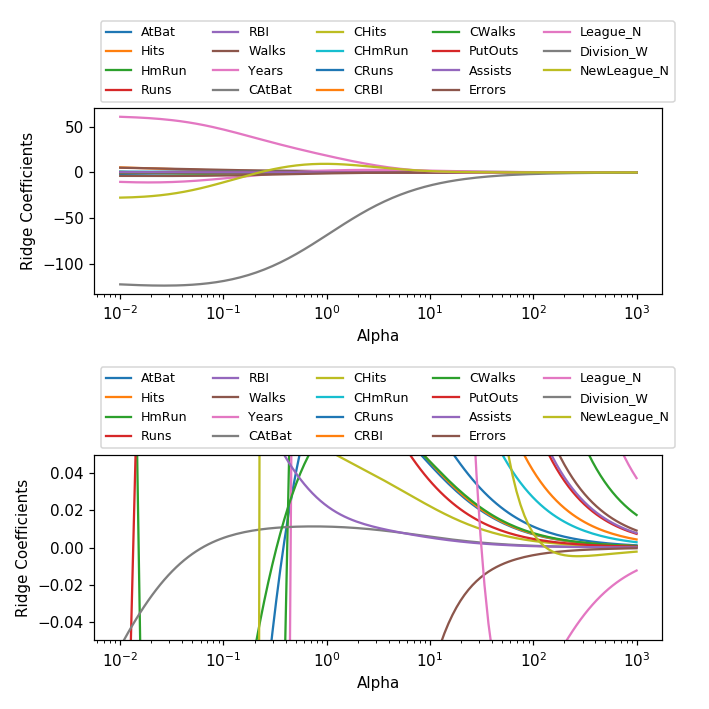

In [26]:
%matplotlib notebook
fig, ax = plt.subplots(2,1,figsize=(6.5,6.5))
for coeff in df_model.index[1:]: 
    ax[0].plot(alphas[:-3], df_model.loc[coeff][:-3], label = coeff)

ax[0].legend(ncol=5, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Ridge Coefficients')
ax[0].semilogx()

for coeff in df_model.index[1:]: 
    ax[1].plot(alphas[:-3], df_model.loc[coeff][:-3], label = coeff)
ax[1].legend(ncol=5, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Ridge Coefficients')
ax[1].semilogx()
ax[1].set_ylim(-0.05,0.05)

plt.tight_layout()
plt.savefig('Ridge Coefficients.png', dpi = 100)
# as we see at large alpha all coefficients become closer to zero but not exactly zero!!

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression

In [27]:
#Validation set approach, we randomly split the data into training and test datasets 
np.random.seed(0)
index = np.random.choice([True, False], size=len(df))
df_train = df[index]
df_test = df[~index]

In [28]:
print('Shape of the whole dataset: {}'.format(df.shape))
print('Shape of training dataset: {}'.format(df_train.shape))
print('Shape of test dataset: {}'.format(df_test.shape))

Shape of the whole dataset: (263, 20)
Shape of training dataset: (130, 20)
Shape of test dataset: (133, 20)


In [32]:
x_train = df_train[features]
y_train = df_train['Salary']
x_test = df_test[features]
y_test = df_test['Salary']

In [33]:
4/len(x_train)/2

0.015384615384615385

In [34]:
model = Ridge(alpha = 2, normalize=True).fit(x_train, y_train)
prediction = model.predict(x_test)
print('MSE on Test dataset {}'.format(np.mean((y_test - prediction)**2)))
   

MSE on Test dataset 157670.67036143754


In [35]:
#Note that if we had instead simply fit a model
#with just an intercept, we would have predicted each test observation using
#the mean of the training observations
print('MSE on Test dataset {}'.format(np.mean((np.mean(y_train) - y_test)**2)))

MSE on Test dataset 246681.89943556327


In [36]:
# We could also get the same result by fitting a ridge regression model with
#a very large value of λ
model = Ridge(alpha = 1e10, normalize=True).fit(x_train, y_train)
prediction = model.predict(x_test)
print('MSE on Test dataset {}'.format(np.mean((y_test - prediction)**2)))

MSE on Test dataset 246681.89929926328


In [37]:
#We now check whether
#there is any benefit to performing ridge regression with λ = 4 instead of
#just performing least squares regression. Recall that least squares is simply
#ridge regression with λ = 0

model = Ridge(alpha = 0, normalize=True).fit(x_train, y_train)
prediction = model.predict(x_test)
print('MSE on Test dataset {}'.format(np.mean((y_test - prediction)**2)))

MSE on Test dataset 156763.43838547886


In [80]:
#In general, instead of arbitrarily choosing alpha = 2, it would be better to
#use cross-validation to choose the tuning parameter alpha. We can do this using
#the built-in cross-validation function

alphas = np.logspace(-6, 2, 100)

# Split data into k10-folds
df_MSE = pd.DataFrame([])
MSE_test = []

kf = KFold(n_splits=10)

MSE_test = []
for alpha in alphas:
    
    error = []
    for train_index, test_index in kf.split(df):

        df_k_train = df.iloc[train_index]
        df_k_test = df.iloc[test_index]
        
        x_train = df_k_train[features]
        y_train = df_k_train['Salary']
        x_test = df_k_test[features]
        y_test = df_k_test['Salary']
        
        model = Ridge(alpha = alpha, normalize=True).fit(x_train, y_train)
        prediction = model.predict(x_test)
        
        error = np.append(error, y_test - prediction) # Note error.append won't work here as 
                                                       # we want to have a single error vector
    MSE_test.append(np.mean(error**2))
    

In [81]:
min_index = np.argmin(MSE_test)
print(min_index)
print('Alpha with minimum MSE: {}'.format(alphas[min_index]))
print('Corresponding MSE: {}'.format(MSE_test[min_index]))

50
Alpha with minimum MSE: 0.010974987654930568
Corresponding MSE: 114076.37391371452


<IPython.core.display.Javascript object>


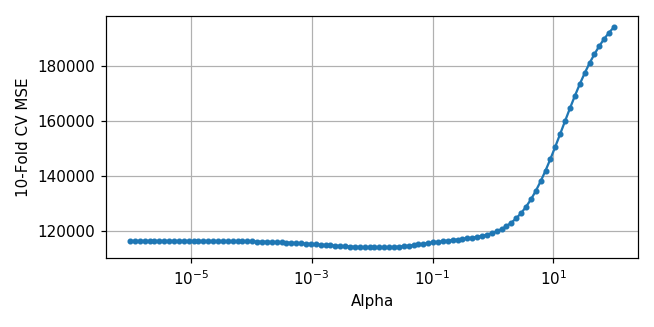

In [86]:
%matplotlib notebook
plt.figure(figsize=(6,3))
plt.plot(alphas, MSE_test, marker = '.')
plt.semilogx()
plt.xlabel('Alpha')
plt.ylabel('10-Fold CV MSE')
plt.grid(which = 'both')
plt.tight_layout()
plt.savefig('10_Fold_CV_MSE.png', dpi = 100)

In [89]:
# Finally, we refit our ridge regression model on the full data set,
# using the value of λ chosen by cross-validation, and examine the coefficient
# estimates.

x = df[features]
y = df['Salary']

model = Ridge(alpha = alphas[min_index], normalize=True).fit(x, y)

df_model = pd.DataFrame([])
df_model['Coefficients'] = np.hstack([model.intercept_, model.coef_])
index = ['Intercept'] + features  
df_model.index = index
df_model

,Coefficients
Intercept,145.018882
AtBat,-1.547145
Hits,5.414210
HmRun,0.486959
Runs,-0.189550
RBI,0.106456
Walks,5.089203
Years,-10.511053
CAtBat,-0.049362
CHits,0.190047


### Lasso

In [108]:
alphas = np.logspace(-2, 3, 130)

lasso_models = []
results = []
df_model = pd.DataFrame([])
for alpha in alphas:
    model = Lasso(alpha = alpha, normalize=True, max_iter=10000)
    lasso_models.append(model.fit(x, y))
    df_model['Alpha {:2.3f}'.format(alpha)] = np.hstack([model.intercept_, model.coef_])

index = ['Intercept'] + features    
df_model.index = index

In [110]:
df_model.head()

,Alpha 0.010,Alpha 0.011,Alpha 0.012,Alpha 0.013,Alpha 0.014,Alpha 0.016,Alpha 0.017,Alpha 0.019,Alpha 0.020,Alpha 0.022,...,Alpha 447.881,Alpha 489.691,Alpha 535.405,Alpha 585.385,Alpha 640.032,Alpha 699.780,Alpha 765.105,Alpha 836.528,Alpha 914.619,Alpha 1000.000
Intercept,161.104637,160.924595,160.728313,160.513674,160.279772,160.025445,159.747400,159.443178,159.113089,158.751684,...,535.925882,535.925882,535.925882,535.925882,535.925882,535.925882,535.925882,535.925882,535.925882,535.925882
AtBat,-1.980122,-1.980299,-1.980505,-1.980729,-1.980993,-1.981313,-1.981663,-1.982041,-1.982513,-1.983017,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hits,7.374319,7.368095,7.361336,7.353943,7.345921,7.337263,7.327798,7.317432,7.306299,7.294087,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HmRun,3.513015,3.464310,3.411039,3.352796,3.289089,3.219388,3.143179,3.059863,2.968684,2.869010,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Runs,-2.106468,-2.091269,-2.074673,-2.056527,-2.036717,-2.015113,-1.991494,-1.965661,-1.937516,-1.906724,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>


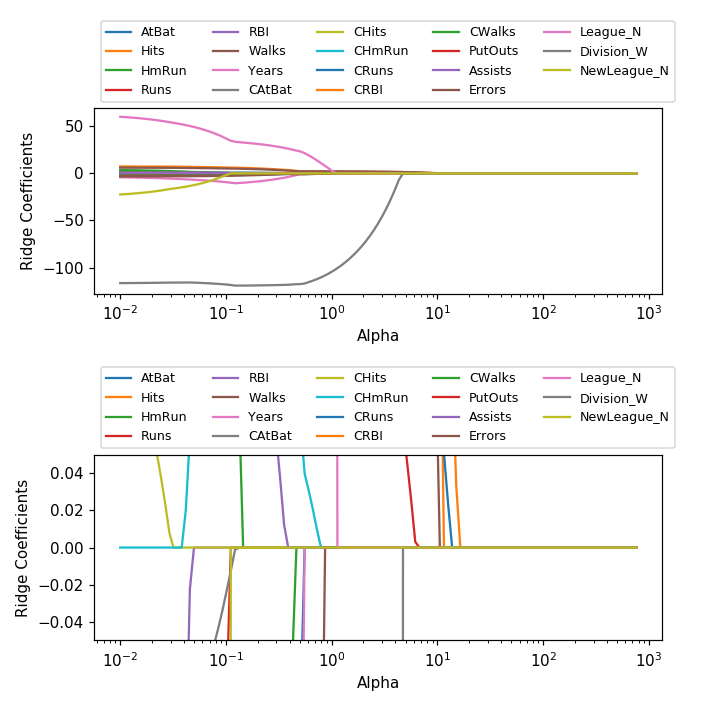

In [111]:
%matplotlib notebook
fig, ax = plt.subplots(2,1,figsize=(6.5,6.5))
for coeff in df_model.index[1:]: 
    ax[0].plot(alphas[:-3], df_model.loc[coeff][:-3], label = coeff)

ax[0].legend(ncol=5, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
ax[0].set_xlabel('Alpha')
ax[0].set_ylabel('Ridge Coefficients')
ax[0].semilogx()

for coeff in df_model.index[1:]: 
    ax[1].plot(alphas[:-3], df_model.loc[coeff][:-3], label = coeff)
ax[1].legend(ncol=5, bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
ax[1].set_xlabel('Alpha')
ax[1].set_ylabel('Ridge Coefficients')
ax[1].semilogx()
ax[1].set_ylim(-0.05,0.05)

plt.tight_layout()
plt.savefig('Lasso Coefficients.png', dpi = 100)
# as we see at large alpha all coefficients become closer to zero but not exactly zero!!

In [112]:
#We now perform cross-validation and compute the associated test error

alphas = np.logspace(-6, 2, 100)

# Split data into k10-folds
df_MSE = pd.DataFrame([])
MSE_test = []

kf = KFold(n_splits=10)

MSE_test = []
for alpha in alphas:
    
    error = []
    for train_index, test_index in kf.split(df):

        df_k_train = df.iloc[train_index]
        df_k_test = df.iloc[test_index]
        
        x_train = df_k_train[features]
        y_train = df_k_train['Salary']
        x_test = df_k_test[features]
        y_test = df_k_test['Salary']
        
        model = Lasso(alpha = alpha, normalize=True, max_iter=10000).fit(x_train, y_train)
        prediction = model.predict(x_test)
        
        error = np.append(error, y_test - prediction) # Note error.append won't work here as 
                                                       # we want to have a single error vector
    MSE_test.append(np.mean(error**2))
    

In [113]:
min_index = np.argmin(MSE_test)
print(min_index)
print('Alpha with minimum MSE: {}'.format(alphas[min_index]))
print('Corresponding MSE: {}'.format(MSE_test[min_index]))

# We see a little better performance compare to Ridge

65
Alpha with minimum MSE: 0.1788649529057435
Corresponding MSE: 113832.90951663764


<IPython.core.display.Javascript object>


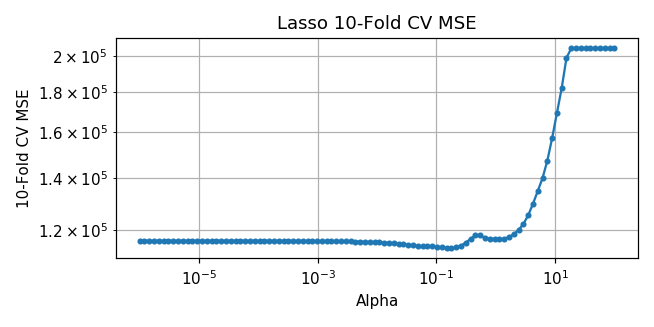

In [116]:
%matplotlib notebook
plt.figure(figsize=(6,3))
plt.plot(alphas, MSE_test, marker = '.')
plt.semilogx()
plt.semilogy()
plt.title('Lasso 10-Fold CV MSE')
plt.xlabel('Alpha')
plt.ylabel('10-Fold CV MSE')
plt.grid(which = 'both')
plt.tight_layout()
plt.savefig('Lasso_10_Fold_CV_MSE.png', dpi = 100)


In [121]:
# Finally, we refit our Lasso regression model on the full data set,
# using the value of alpha chosen by cross-validation, and examine the coefficient
# estimates.

x = df[features]
y = df['Salary']

model = Lasso(alpha = alphas[min_index], normalize=True, max_iter=10000).fit(x, y)

df_model = pd.DataFrame([])
df_model['Coefficients'] = np.hstack([model.intercept_, model.coef_])
index = ['Intercept'] + features  
df_model.index = index

# We see that only 8 features have non-zero coefficients, the rest have zero ones.
# This make the model highly interpretable compared to Ridge
df_model[df_model['Coefficients'] > 0]

,Coefficients
Intercept,118.110130
Hits,5.557153
Walks,4.630460
CHmRun,0.510315
CRuns,0.644785
CRBI,0.383826
PutOuts,0.271157
Assists,0.162300
League_N,31.863229


In [122]:
df_model[df_model['Coefficients'] == 0]

,Coefficients
HmRun,0.0
Runs,-0.0
RBI,0.0
CAtBat,-0.0
CHits,0.0
NewLeague_N,-0.0
